**Combien gagne-t-on sur ses factures d’électricité (en kWh / an, voire en euros par an en prenant des hypothèses tarifaires) à passer d’une classe de DPE à une autre (ex : de G à F, ou de F à E, la valeur recherchée dépendant des classes concernées) ?**

# Librairies

In [ ]:
pip install plotly

   ---------------------------------------- 0.0/19.1 MB ? eta -:--:--
   --- ------------------------------------ 1.8/19.1 MB 16.7 MB/s eta 0:00:02
   ------------- -------------------------- 6.3/19.1 MB 27.5 MB/s eta 0:00:01
   -------------------------------- ------- 15.5/19.1 MB 28.6 MB/s eta 0:00:01
   ---------------------------------------- 19.1/19.1 MB 28.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import pandas as pd
import re
import unicodedata
from unidecode import unidecode
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px

In [ ]:
pd.set_option('display.max_columns', None)

# Importation des données

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
path = '/content/drive/MyDrive/PIP 2025/Rendu final/Problématique 1'

In [ ]:
# Chargement par morceaux
chunksize = 10000  # Nombre de lignes par morceau
chunks = pd.read_csv(path + '/#conso_dpe_pb1.csv', sep=',', chunksize=chunksize)

# Traiter les morceaux un par un (concaténation)
df_list = []
for chunk in chunks:
    df_list.append(chunk)

conso_dpe = pd.concat(df_list, ignore_index=True)

In [ ]:
conso_dpe.shape

(3555581, 32)

# Couleurs DPE

In [ ]:
# Couleurs officielles des classes DPE
dpe_colors = {
    'A': '#00cc00',  # Vert foncé
    'B': '#66ff66',  # Vert clair
    'C': '#ffff00',  # Jaune
    'D': '#ffcc00',  # Orange clair
    'E': '#ff9900',  # Orange foncé
    'F': '#ff3300',  # Rouge clair
    'G': '#cc0000'   # Rouge foncé
}

# Liste des colonnes

In [ ]:
conso_dpe.columns.to_list()

['Etiquette_DPE',
 'Conso_5_usages_é_finale_énergie_n°1',
 'Conso_5_usages_énergie_n°1',
 'Surface_habitable_logement',
 'Type_énergie_n°1',
 'Type_bâtiment',
 'Adresse_(BAN)',
 'N°_département_(BAN)',
 'Coordonnée_cartographique_X_(BAN)',
 'Coordonnée_cartographique_Y_(BAN)',
 'N°_voie_(BAN)',
 'Nom__rue_(BAN)',
 'Nom__commune_(BAN)',
 'Année',
 'Code IRIS',
 'Nom IRIS',
 'Numéro de voie',
 'Indice de répétition',
 'Type de voie',
 'Libellé de voie',
 'Code Commune',
 'Nom Commune',
 'Segment de client',
 'Nombre de logements',
 "Consommation annuelle totale de l'adresse (MWh)",
 "Consommation annuelle moyenne par logement de l'adresse (MWh)",
 'Consommation annuelle moyenne de la commune (MWh)',
 'Adresse',
 'Code EPCI',
 'Code Département',
 'Code Région',
 'Tri des adresses']

# Supprimer colonnes inutiles

In [ ]:
colonnes_a_supprimer = [
    'Année',
    'Code IRIS',
    'Nom IRIS',
    'Numéro de voie',
    'Indice de répétition',
    'Type de voie',
    'Libellé de voie',
    'Code Commune',
    'Nom Commune',
    'Segment de client',
    'Nombre de logements',
    "Consommation annuelle totale de l'adresse (MWh)",
    'Consommation annuelle moyenne de la commune (MWh)',
    'Adresse',
    'Code EPCI',
    'Code Département',
    'Code Région',
    'Tri des adresses'
]

# Suppression des colonnes
conso_dpe = conso_dpe.drop(columns=colonnes_a_supprimer)


# Transformation Mwh en kWh

In [ ]:
# Conversion de la consommation réelle en kWh
conso_dpe['Consommation réelle (kWh)'] = conso_dpe["Consommation annuelle moyenne par logement de l'adresse (MWh)"] * 1000

In [ ]:
conso_dpe['Consommation réelle (kWh)']

0          1002.0
1          1002.0
2          1002.0
3          1002.0
4          1002.0
            ...  
3555576    2748.0
3555577    2696.0
3555578    2626.0
3555579    2614.0
3555580    2639.0
Name: Consommation réelle (kWh), Length: 3555581, dtype: float64

# Consommation réelle par m²

In [ ]:
# Calcul de la consommation réelle par m²
conso_real_m2 = conso_dpe['Consommation réelle (kWh)'] / conso_dpe['Surface_habitable_logement']
conso_dpe['Conso_real_m²'] = conso_real_m2

# Consommation estimée par m²

In [ ]:
# Calcul de la consommation réelle par m²
conso_estimee_m2 = conso_dpe['Conso_5_usages_é_finale_énergie_n°1'] / conso_dpe['Surface_habitable_logement']
conso_dpe['Conso_estimée_m²'] = conso_estimee_m2

# GAINS

## Filtrer sur ELECTRICITE et MAISON, APPARTEMENT

In [ ]:
df = conso_dpe[conso_dpe['Type_énergie_n°1']== 'ELECTRICITE']
df = df[df['Type_bâtiment'].isin(['APPARTEMENT','MAISON'])]

## CREATION  DE DATASETS DIFERENTS SELON ETIQUETTES DPE

In [ ]:
df_etiquette_A= df[df['Etiquette_DPE']=='A']
df_etiquette_B= df[df['Etiquette_DPE']=='B']
df_etiquette_C= df[df['Etiquette_DPE']=='C']
df_etiquette_D= df[df['Etiquette_DPE']=='D']
df_etiquette_E= df[df['Etiquette_DPE']=='E']
df_etiquette_F= df[df['Etiquette_DPE']=='F']
df_etiquette_G= df[df['Etiquette_DPE']=='G']

## Moyenne consommation réelle m²

In [ ]:
labels = ['A','B', 'C', 'D', 'E', 'F', 'G']

mean_A_conso = df_etiquette_A["Conso_real_m²"].mean()
mean_B_conso = df_etiquette_B["Conso_real_m²"].mean()
mean_C_conso = df_etiquette_C["Conso_real_m²"].mean()
mean_D_conso = df_etiquette_D["Conso_real_m²"].mean()
mean_E_conso = df_etiquette_E["Conso_real_m²"].mean()
mean_F_conso = df_etiquette_F["Conso_real_m²"].mean()
mean_G_conso = df_etiquette_G["Conso_real_m²"].mean()
mean_total_conso=[ mean_A_conso,mean_B_conso,mean_C_conso,mean_D_conso,mean_E_conso,mean_F_conso,mean_G_conso]

## COMPARAISON DE GAIN  THEORIQUE QU'ON GAGNE SELON LA CONSO REEL AU METRE CARRE en kwh et en €

### Valeurs brutes

Consommation moyenne (A) : 55 kWh
Consommation moyenne (B) : 63 kWh
Gain de consommation entre A et B : 7 kWh
Gains en euros entre A et B: 1 €
----------------------------------------
Consommation moyenne (A) : 55 kWh
Consommation moyenne (C) : 88 kWh
Gain de consommation entre A et C : 33 kWh
Gains en euros entre A et C: 6 €
----------------------------------------
Consommation moyenne (A) : 55 kWh
Consommation moyenne (D) : 98 kWh
Gain de consommation entre A et D : 43 kWh
Gains en euros entre A et D: 8 €
----------------------------------------
Consommation moyenne (A) : 55 kWh
Consommation moyenne (E) : 104 kWh
Gain de consommation entre A et E : 48 kWh
Gains en euros entre A et E: 9 €
----------------------------------------
Consommation moyenne (A) : 55 kWh
Consommation moyenne (F) : 112 kWh
Gain de consommation entre A et F : 57 kWh
Gains en euros entre A et F: 11 €
----------------------------------------
Consommation moyenne (A) : 55 kWh
Consommation moyenne (G) : 144 kWh
Gain

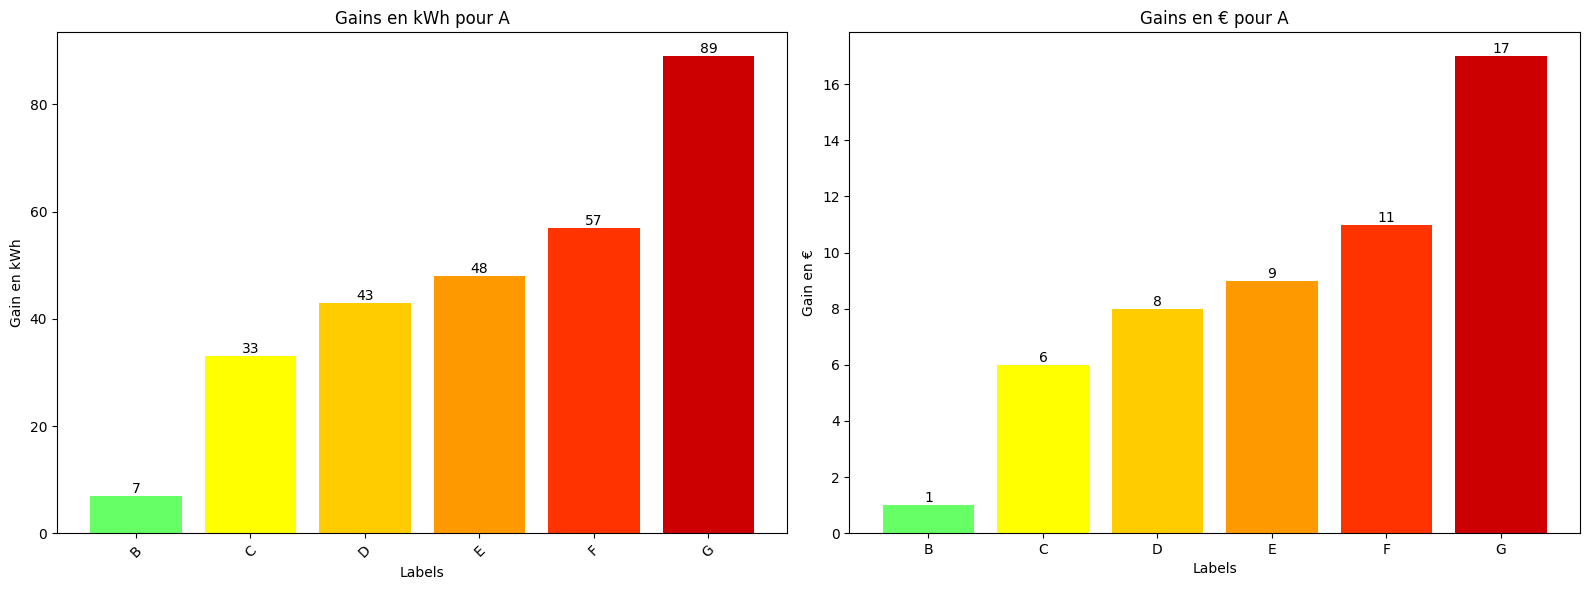

Consommation moyenne (B) : 63 kWh
Consommation moyenne (A) : 55 kWh
Gain de consommation entre B et A : -7 kWh
Gains en euros entre B et A: -1 €
----------------------------------------
Consommation moyenne (B) : 63 kWh
Consommation moyenne (C) : 88 kWh
Gain de consommation entre B et C : 25 kWh
Gains en euros entre B et C: 5 €
----------------------------------------
Consommation moyenne (B) : 63 kWh
Consommation moyenne (D) : 98 kWh
Gain de consommation entre B et D : 35 kWh
Gains en euros entre B et D: 7 €
----------------------------------------
Consommation moyenne (B) : 63 kWh
Consommation moyenne (E) : 104 kWh
Gain de consommation entre B et E : 41 kWh
Gains en euros entre B et E: 8 €
----------------------------------------
Consommation moyenne (B) : 63 kWh
Consommation moyenne (F) : 112 kWh
Gain de consommation entre B et F : 49 kWh
Gains en euros entre B et F: 9 €
----------------------------------------
Consommation moyenne (B) : 63 kWh
Consommation moyenne (G) : 144 kWh
Gai

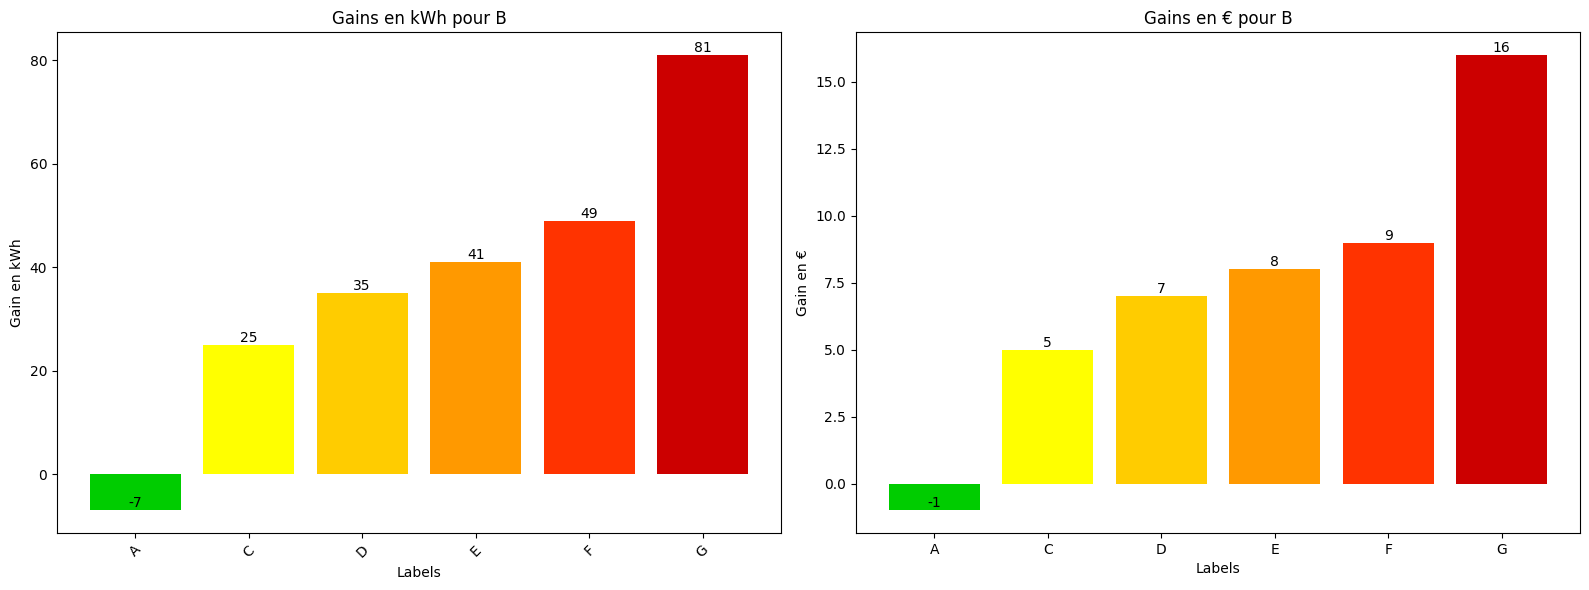

Consommation moyenne (C) : 88 kWh
Consommation moyenne (A) : 55 kWh
Gain de consommation entre C et A : -33 kWh
Gains en euros entre C et A: -6 €
----------------------------------------
Consommation moyenne (C) : 88 kWh
Consommation moyenne (B) : 63 kWh
Gain de consommation entre C et B : -25 kWh
Gains en euros entre C et B: -5 €
----------------------------------------
Consommation moyenne (C) : 88 kWh
Consommation moyenne (D) : 98 kWh
Gain de consommation entre C et D : 9 kWh
Gains en euros entre C et D: 1 €
----------------------------------------
Consommation moyenne (C) : 88 kWh
Consommation moyenne (E) : 104 kWh
Gain de consommation entre C et E : 15 kWh
Gains en euros entre C et E: 3 €
----------------------------------------
Consommation moyenne (C) : 88 kWh
Consommation moyenne (F) : 112 kWh
Gain de consommation entre C et F : 23 kWh
Gains en euros entre C et F: 4 €
----------------------------------------
Consommation moyenne (C) : 88 kWh
Consommation moyenne (G) : 144 kWh
G

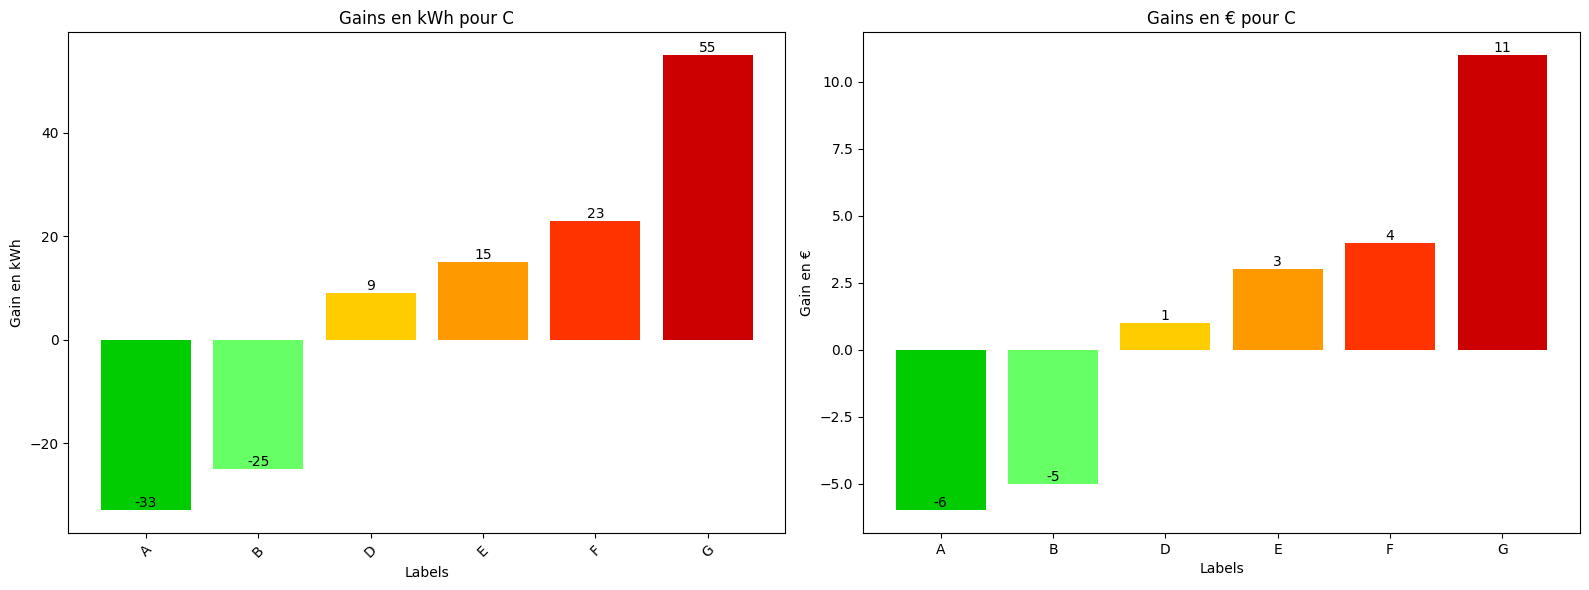

Consommation moyenne (D) : 98 kWh
Consommation moyenne (A) : 55 kWh
Gain de consommation entre D et A : -43 kWh
Gains en euros entre D et A: -8 €
----------------------------------------
Consommation moyenne (D) : 98 kWh
Consommation moyenne (B) : 63 kWh
Gain de consommation entre D et B : -35 kWh
Gains en euros entre D et B: -7 €
----------------------------------------
Consommation moyenne (D) : 98 kWh
Consommation moyenne (C) : 88 kWh
Gain de consommation entre D et C : -9 kWh
Gains en euros entre D et C: -1 €
----------------------------------------
Consommation moyenne (D) : 98 kWh
Consommation moyenne (E) : 104 kWh
Gain de consommation entre D et E : 5 kWh
Gains en euros entre D et E: 1 €
----------------------------------------
Consommation moyenne (D) : 98 kWh
Consommation moyenne (F) : 112 kWh
Gain de consommation entre D et F : 13 kWh
Gains en euros entre D et F: 2 €
----------------------------------------
Consommation moyenne (D) : 98 kWh
Consommation moyenne (G) : 144 kWh


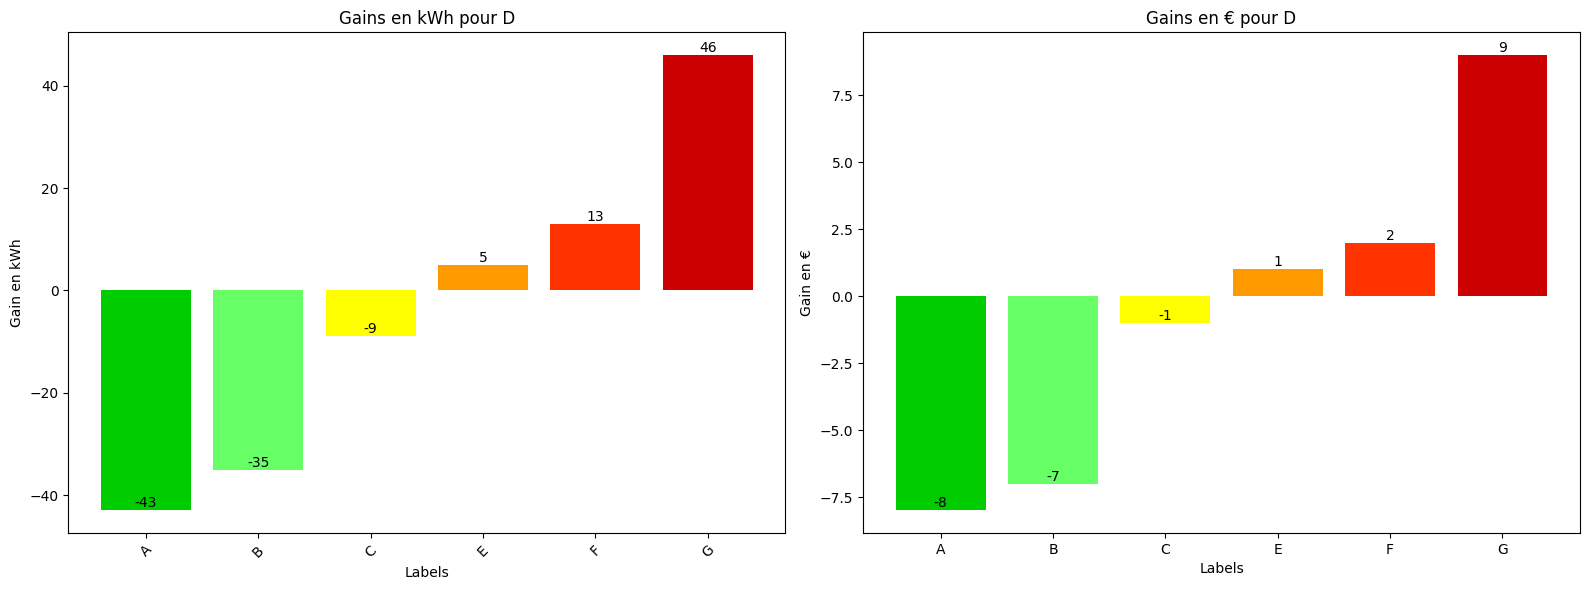

Consommation moyenne (E) : 104 kWh
Consommation moyenne (A) : 55 kWh
Gain de consommation entre E et A : -48 kWh
Gains en euros entre E et A: -9 €
----------------------------------------
Consommation moyenne (E) : 104 kWh
Consommation moyenne (B) : 63 kWh
Gain de consommation entre E et B : -41 kWh
Gains en euros entre E et B: -8 €
----------------------------------------
Consommation moyenne (E) : 104 kWh
Consommation moyenne (C) : 88 kWh
Gain de consommation entre E et C : -15 kWh
Gains en euros entre E et C: -3 €
----------------------------------------
Consommation moyenne (E) : 104 kWh
Consommation moyenne (D) : 98 kWh
Gain de consommation entre E et D : -5 kWh
Gains en euros entre E et D: -1 €
----------------------------------------
Consommation moyenne (E) : 104 kWh
Consommation moyenne (F) : 112 kWh
Gain de consommation entre E et F : 8 kWh
Gains en euros entre E et F: 1 €
----------------------------------------
Consommation moyenne (E) : 104 kWh
Consommation moyenne (G) : 1

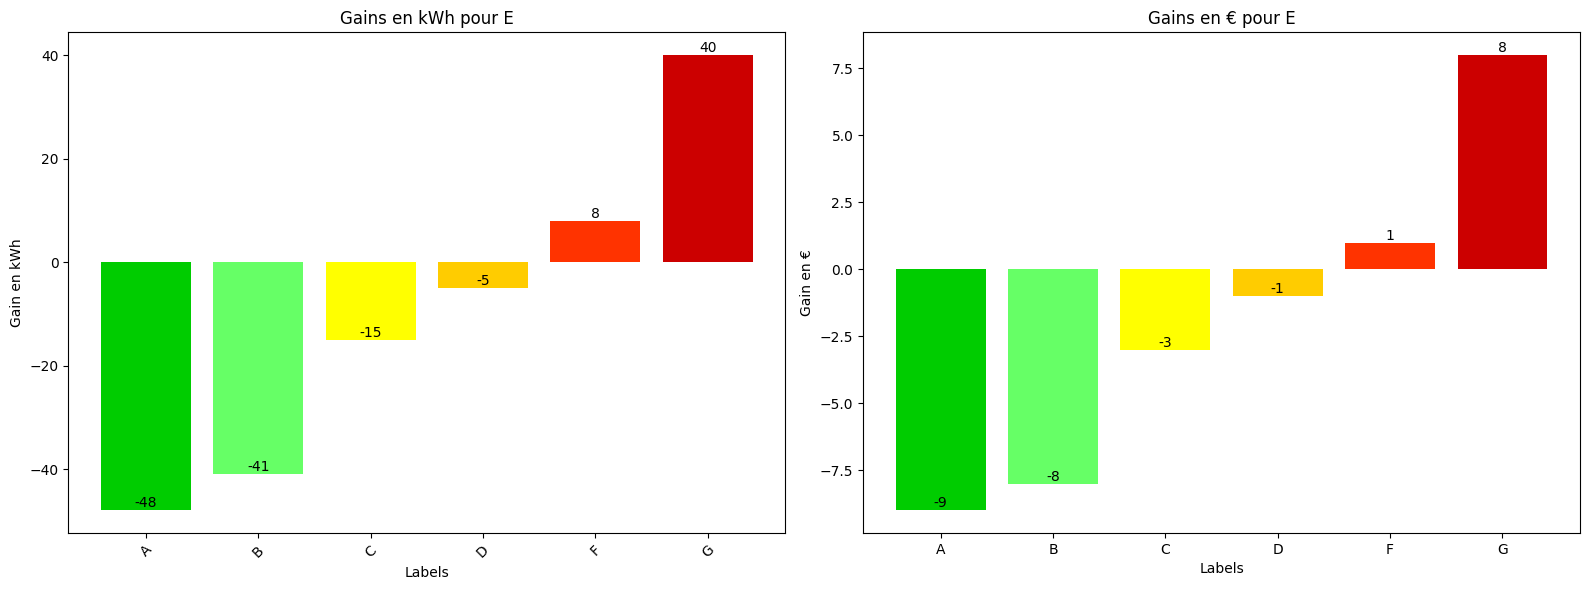

Consommation moyenne (F) : 112 kWh
Consommation moyenne (A) : 55 kWh
Gain de consommation entre F et A : -57 kWh
Gains en euros entre F et A: -11 €
----------------------------------------
Consommation moyenne (F) : 112 kWh
Consommation moyenne (B) : 63 kWh
Gain de consommation entre F et B : -49 kWh
Gains en euros entre F et B: -9 €
----------------------------------------
Consommation moyenne (F) : 112 kWh
Consommation moyenne (C) : 88 kWh
Gain de consommation entre F et C : -23 kWh
Gains en euros entre F et C: -4 €
----------------------------------------
Consommation moyenne (F) : 112 kWh
Consommation moyenne (D) : 98 kWh
Gain de consommation entre F et D : -13 kWh
Gains en euros entre F et D: -2 €
----------------------------------------
Consommation moyenne (F) : 112 kWh
Consommation moyenne (E) : 104 kWh
Gain de consommation entre F et E : -8 kWh
Gains en euros entre F et E: -1 €
----------------------------------------
Consommation moyenne (F) : 112 kWh
Consommation moyenne (G)

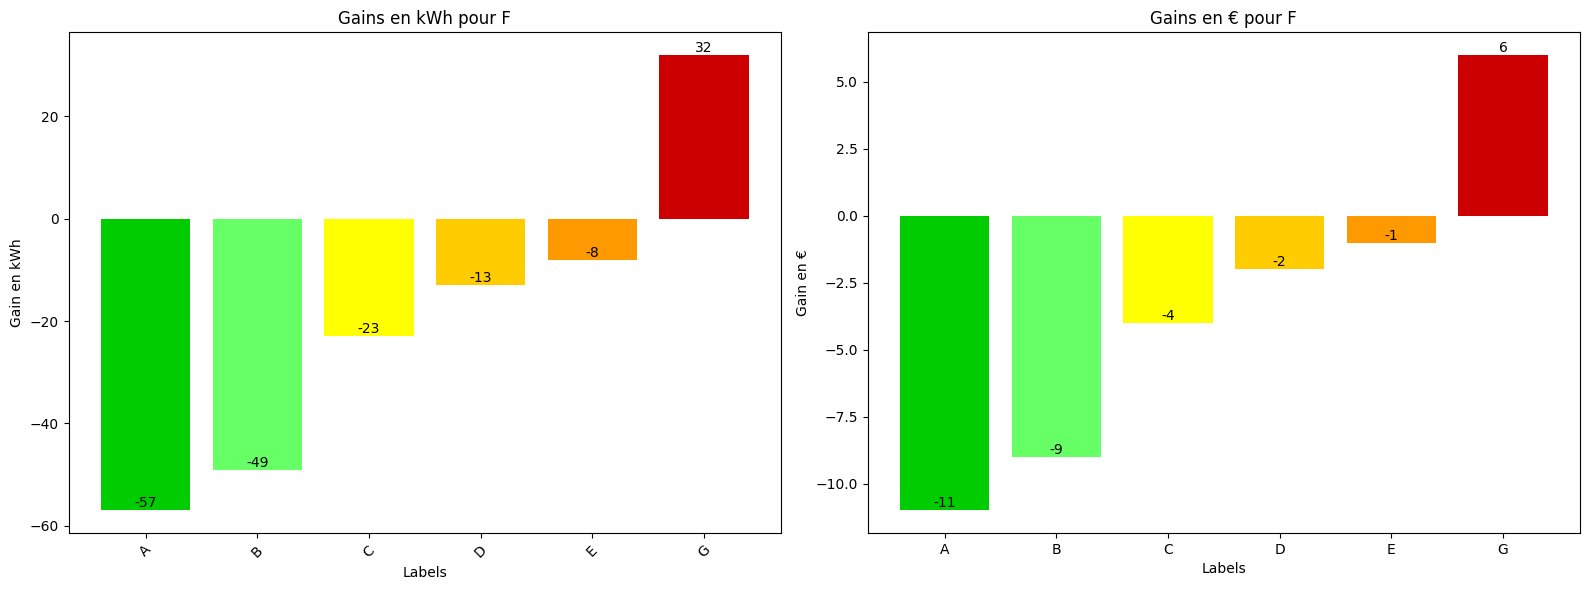

Consommation moyenne (G) : 144 kWh
Consommation moyenne (A) : 55 kWh
Gain de consommation entre G et A : -89 kWh
Gains en euros entre G et A: -17 €
----------------------------------------
Consommation moyenne (G) : 144 kWh
Consommation moyenne (B) : 63 kWh
Gain de consommation entre G et B : -81 kWh
Gains en euros entre G et B: -16 €
----------------------------------------
Consommation moyenne (G) : 144 kWh
Consommation moyenne (C) : 88 kWh
Gain de consommation entre G et C : -55 kWh
Gains en euros entre G et C: -11 €
----------------------------------------
Consommation moyenne (G) : 144 kWh
Consommation moyenne (D) : 98 kWh
Gain de consommation entre G et D : -46 kWh
Gains en euros entre G et D: -9 €
----------------------------------------
Consommation moyenne (G) : 144 kWh
Consommation moyenne (E) : 104 kWh
Gain de consommation entre G et E : -40 kWh
Gains en euros entre G et E: -8 €
----------------------------------------
Consommation moyenne (G) : 144 kWh
Consommation moyenne 

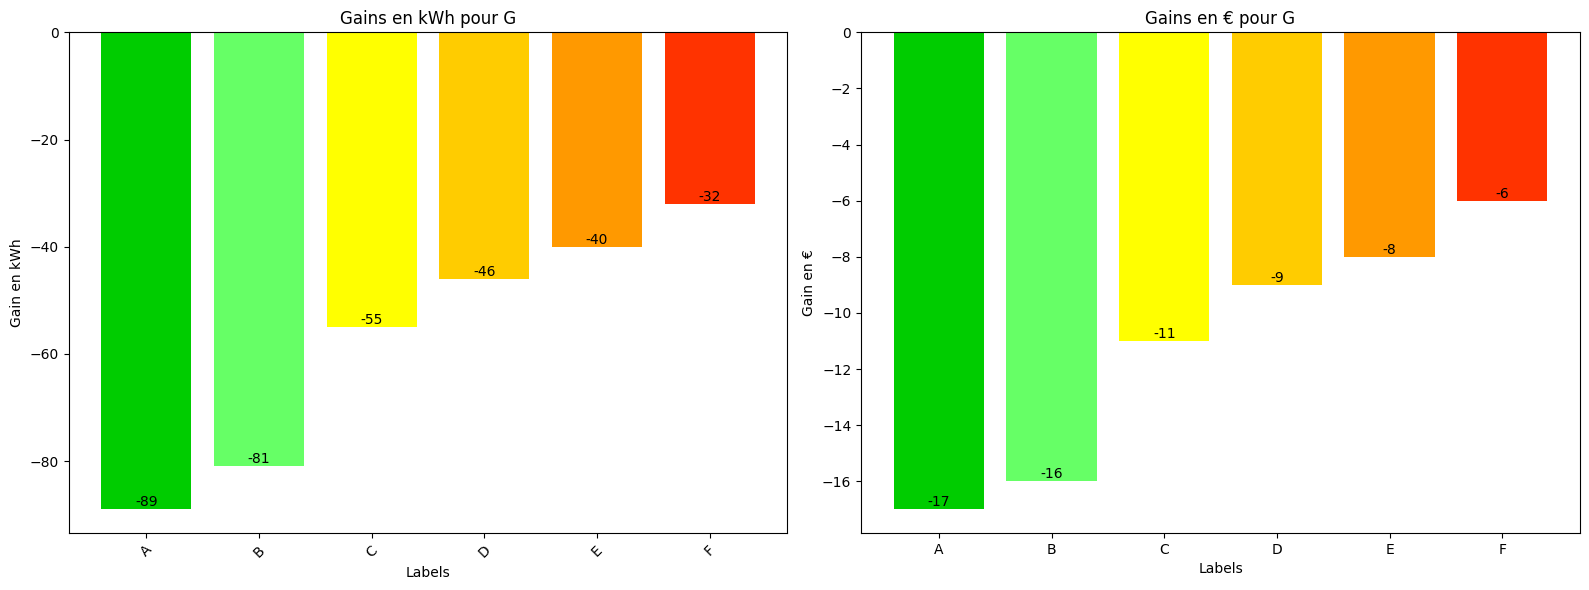

In [ ]:
for j, label in zip(mean_total_conso, labels):
    gain_total_A = []
    comparison_labels = []

    for i, other_label in zip(mean_total_conso, labels):
        if label != other_label:
            gain_kWh = (-j + i)
            gain_total_A.append(gain_kWh)
            comparison_labels.append(other_label)
            gains_euros = int(gain_kWh * 0.2)  # Conversion à l'entier

            # Print details
            print(f"Consommation moyenne ({label}) : {int(j)} kWh")
            print(f"Consommation moyenne ({other_label}) : {int(i)} kWh")
            print(f"Gain de consommation entre {label} et {other_label} : {int(gain_kWh)} kWh")
            print(f"Gains en euros entre {label} et {other_label}: {gains_euros} €")
            print("-" * 40)

    # Associer les couleurs selon le DPE
    colors = [dpe_colors[dpe] for dpe in comparison_labels]

    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)  # Premier graphique : kWh
    bars_kwh = plt.bar(comparison_labels, [int(g) for g in gain_total_A], color=colors)
    plt.title(f"Gains en kWh pour {label}")
    plt.xlabel("Labels")
    plt.ylabel("Gain en kWh")
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Ajouter les valeurs au-dessus des barres pour kWh
    for bar, h in zip(bars_kwh, [int(g) for g in gain_total_A]):
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{h}', ha='center', va='bottom')

    plt.subplot(1, 2, 2)  # Deuxième graphique : €
    bars_euros = plt.bar(comparison_labels, [int(g * 0.2) for g in gain_total_A], color=colors)
    plt.title(f"Gains en € pour {label}")
    plt.xlabel("Labels")
    plt.ylabel("Gain en €")

    # Ajouter les valeurs au-dessus des barres pour €
    for bar, h in zip(bars_euros, [int(g * 0.2) for g in gain_total_A]):
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{h}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()


### en %

Consommation moyenne (A) : 55 kWh
Consommation moyenne (B) : 63 kWh
Gain de consommation entre A et B : 13.57%
Gains en euros entre A et B: 2.00 €
----------------------------------------
Consommation moyenne (A) : 55 kWh
Consommation moyenne (C) : 88 kWh
Gain de consommation entre A et C : 59.63%
Gains en euros entre A et C: 11.00 €
----------------------------------------
Consommation moyenne (A) : 55 kWh
Consommation moyenne (D) : 98 kWh
Gain de consommation entre A et D : 77.21%
Gains en euros entre A et D: 15.00 €
----------------------------------------
Consommation moyenne (A) : 55 kWh
Consommation moyenne (E) : 104 kWh
Gain de consommation entre A et E : 87.49%
Gains en euros entre A et E: 17.00 €
----------------------------------------
Consommation moyenne (A) : 55 kWh
Consommation moyenne (F) : 112 kWh
Gain de consommation entre A et F : 102.30%
Gains en euros entre A et F: 20.00 €
----------------------------------------
Consommation moyenne (A) : 55 kWh
Consommation moyenn

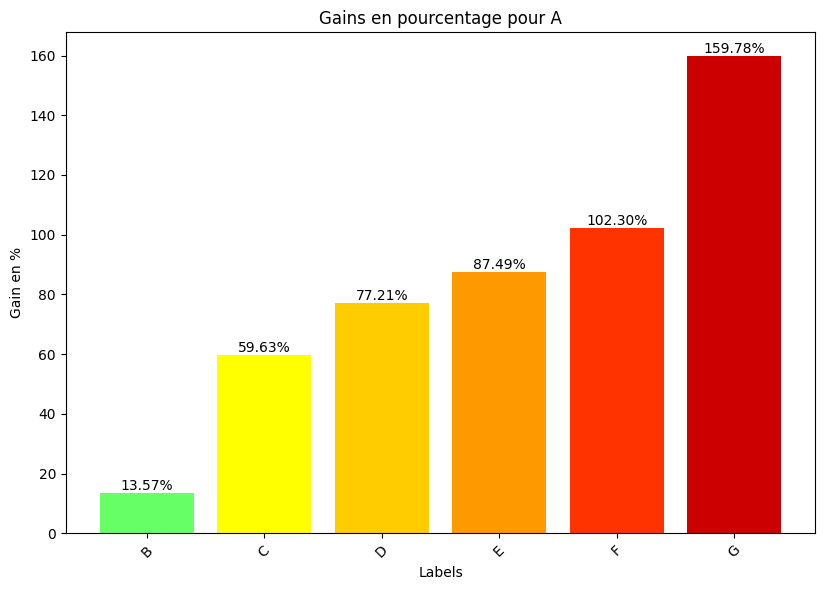

Consommation moyenne (B) : 63 kWh
Consommation moyenne (A) : 55 kWh
Gain de consommation entre B et A : -11.95%
Gains en euros entre B et A: -2.00 €
----------------------------------------
Consommation moyenne (B) : 63 kWh
Consommation moyenne (C) : 88 kWh
Gain de consommation entre B et C : 40.55%
Gains en euros entre B et C: 8.00 €
----------------------------------------
Consommation moyenne (B) : 63 kWh
Consommation moyenne (D) : 98 kWh
Gain de consommation entre B et D : 56.03%
Gains en euros entre B et D: 11.00 €
----------------------------------------
Consommation moyenne (B) : 63 kWh
Consommation moyenne (E) : 104 kWh
Gain de consommation entre B et E : 65.08%
Gains en euros entre B et E: 13.00 €
----------------------------------------
Consommation moyenne (B) : 63 kWh
Consommation moyenne (F) : 112 kWh
Gain de consommation entre B et F : 78.12%
Gains en euros entre B et F: 15.00 €
----------------------------------------
Consommation moyenne (B) : 63 kWh
Consommation moyenn

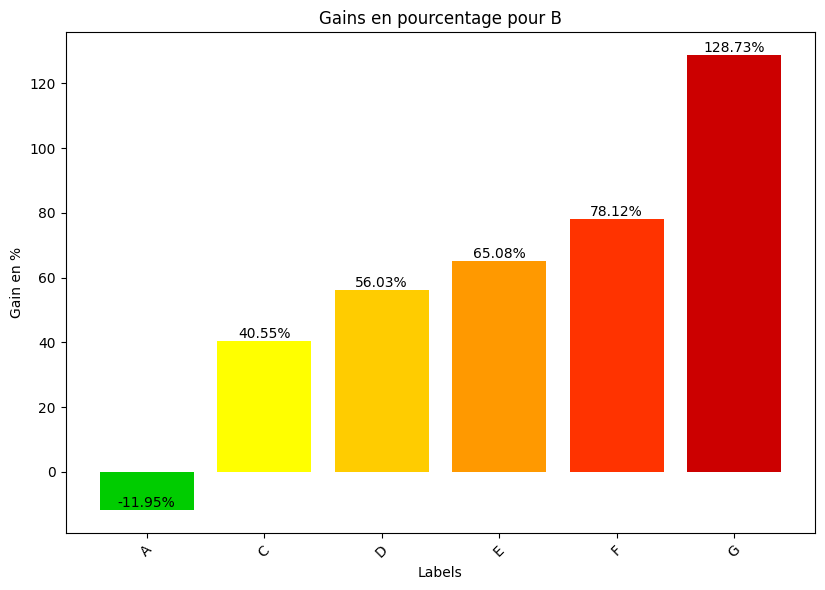

Consommation moyenne (C) : 88 kWh
Consommation moyenne (A) : 55 kWh
Gain de consommation entre C et A : -37.35%
Gains en euros entre C et A: -7.00 €
----------------------------------------
Consommation moyenne (C) : 88 kWh
Consommation moyenne (B) : 63 kWh
Gain de consommation entre C et B : -28.85%
Gains en euros entre C et B: -5.00 €
----------------------------------------
Consommation moyenne (C) : 88 kWh
Consommation moyenne (D) : 98 kWh
Gain de consommation entre C et D : 11.01%
Gains en euros entre C et D: 2.00 €
----------------------------------------
Consommation moyenne (C) : 88 kWh
Consommation moyenne (E) : 104 kWh
Gain de consommation entre C et E : 17.45%
Gains en euros entre C et E: 3.00 €
----------------------------------------
Consommation moyenne (C) : 88 kWh
Consommation moyenne (F) : 112 kWh
Gain de consommation entre C et F : 26.73%
Gains en euros entre C et F: 5.00 €
----------------------------------------
Consommation moyenne (C) : 88 kWh
Consommation moyenne

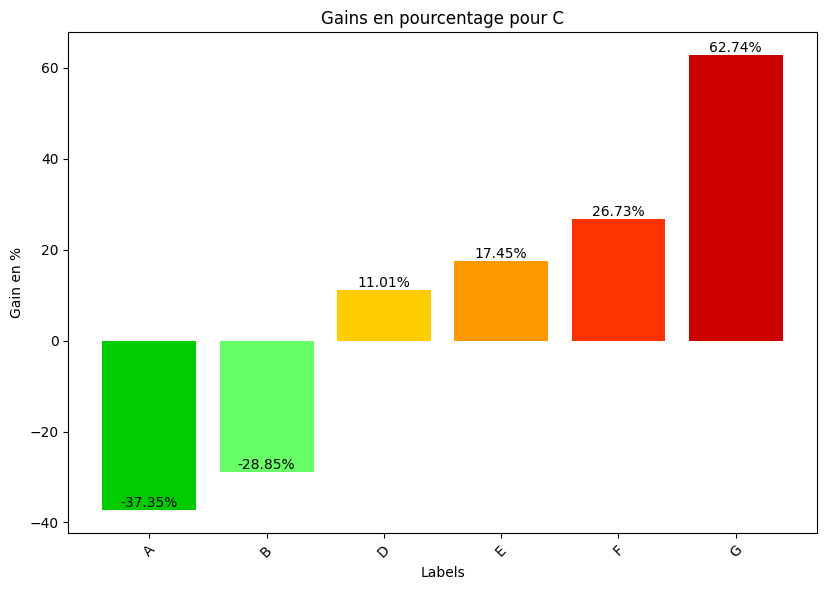

Consommation moyenne (D) : 98 kWh
Consommation moyenne (A) : 55 kWh
Gain de consommation entre D et A : -43.57%
Gains en euros entre D et A: -8.00 €
----------------------------------------
Consommation moyenne (D) : 98 kWh
Consommation moyenne (B) : 63 kWh
Gain de consommation entre D et B : -35.91%
Gains en euros entre D et B: -7.00 €
----------------------------------------
Consommation moyenne (D) : 98 kWh
Consommation moyenne (C) : 88 kWh
Gain de consommation entre D et C : -9.92%
Gains en euros entre D et C: -1.00 €
----------------------------------------
Consommation moyenne (D) : 98 kWh
Consommation moyenne (E) : 104 kWh
Gain de consommation entre D et E : 5.80%
Gains en euros entre D et E: 1.00 €
----------------------------------------
Consommation moyenne (D) : 98 kWh
Consommation moyenne (F) : 112 kWh
Gain de consommation entre D et F : 14.16%
Gains en euros entre D et F: 2.00 €
----------------------------------------
Consommation moyenne (D) : 98 kWh
Consommation moyenne

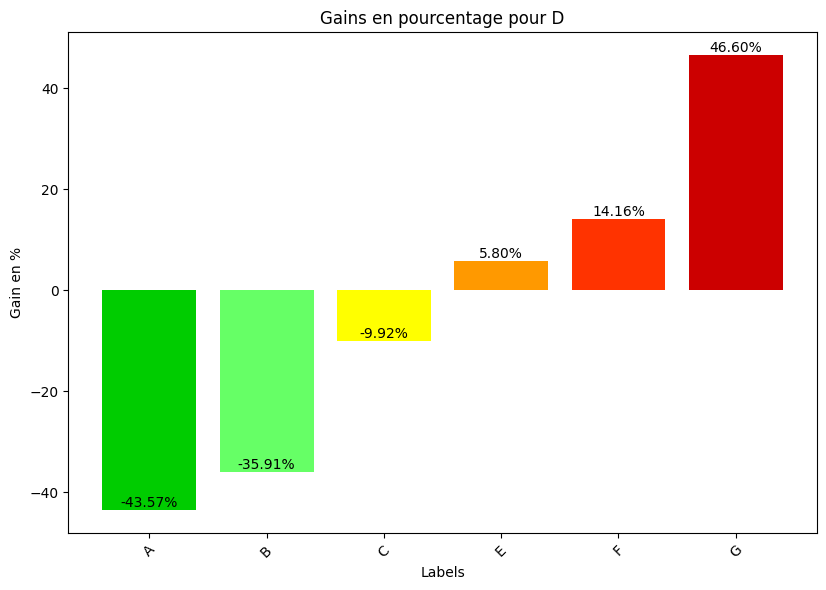

Consommation moyenne (E) : 104 kWh
Consommation moyenne (A) : 55 kWh
Gain de consommation entre E et A : -46.66%
Gains en euros entre E et A: -9.00 €
----------------------------------------
Consommation moyenne (E) : 104 kWh
Consommation moyenne (B) : 63 kWh
Gain de consommation entre E et B : -39.42%
Gains en euros entre E et B: -7.00 €
----------------------------------------
Consommation moyenne (E) : 104 kWh
Consommation moyenne (C) : 88 kWh
Gain de consommation entre E et C : -14.86%
Gains en euros entre E et C: -2.00 €
----------------------------------------
Consommation moyenne (E) : 104 kWh
Consommation moyenne (D) : 98 kWh
Gain de consommation entre E et D : -5.48%
Gains en euros entre E et D: -1.00 €
----------------------------------------
Consommation moyenne (E) : 104 kWh
Consommation moyenne (F) : 112 kWh
Gain de consommation entre E et F : 7.90%
Gains en euros entre E et F: 1.00 €
----------------------------------------
Consommation moyenne (E) : 104 kWh
Consommation 

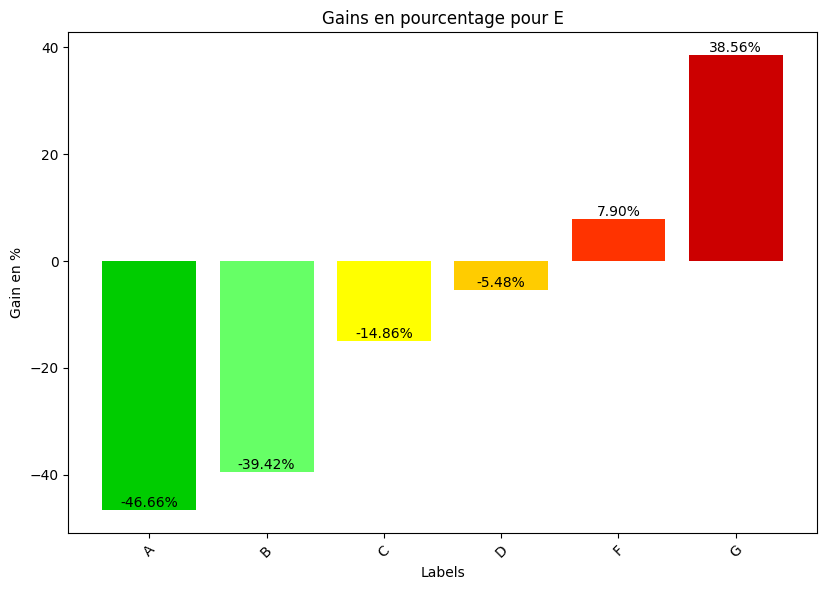

Consommation moyenne (F) : 112 kWh
Consommation moyenne (A) : 55 kWh
Gain de consommation entre F et A : -50.57%
Gains en euros entre F et A: -10.00 €
----------------------------------------
Consommation moyenne (F) : 112 kWh
Consommation moyenne (B) : 63 kWh
Gain de consommation entre F et B : -43.86%
Gains en euros entre F et B: -8.00 €
----------------------------------------
Consommation moyenne (F) : 112 kWh
Consommation moyenne (C) : 88 kWh
Gain de consommation entre F et C : -21.09%
Gains en euros entre F et C: -4.00 €
----------------------------------------
Consommation moyenne (F) : 112 kWh
Consommation moyenne (D) : 98 kWh
Gain de consommation entre F et D : -12.40%
Gains en euros entre F et D: -2.00 €
----------------------------------------
Consommation moyenne (F) : 112 kWh
Consommation moyenne (E) : 104 kWh
Gain de consommation entre F et E : -7.32%
Gains en euros entre F et E: -1.00 €
----------------------------------------
Consommation moyenne (F) : 112 kWh
Consommat

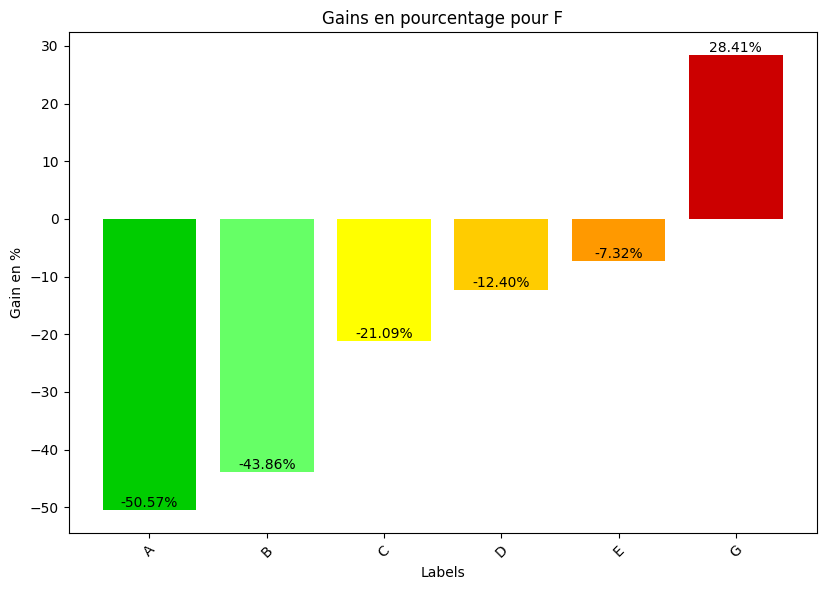

Consommation moyenne (G) : 144 kWh
Consommation moyenne (A) : 55 kWh
Gain de consommation entre G et A : -61.51%
Gains en euros entre G et A: -12.00 €
----------------------------------------
Consommation moyenne (G) : 144 kWh
Consommation moyenne (B) : 63 kWh
Gain de consommation entre G et B : -56.28%
Gains en euros entre G et B: -11.00 €
----------------------------------------
Consommation moyenne (G) : 144 kWh
Consommation moyenne (C) : 88 kWh
Gain de consommation entre G et C : -38.55%
Gains en euros entre G et C: -7.00 €
----------------------------------------
Consommation moyenne (G) : 144 kWh
Consommation moyenne (D) : 98 kWh
Gain de consommation entre G et D : -31.79%
Gains en euros entre G et D: -6.00 €
----------------------------------------
Consommation moyenne (G) : 144 kWh
Consommation moyenne (E) : 104 kWh
Gain de consommation entre G et E : -27.83%
Gains en euros entre G et E: -5.00 €
----------------------------------------
Consommation moyenne (G) : 144 kWh
Consomm

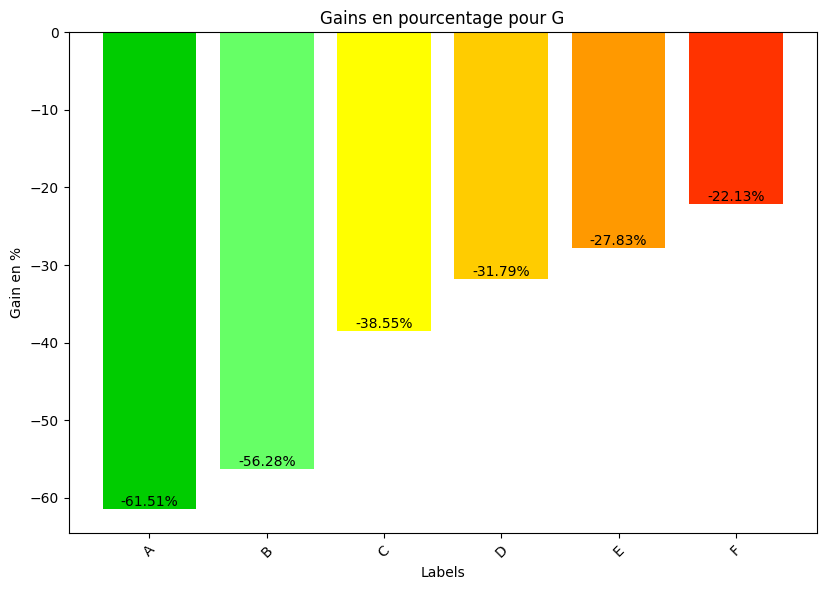

In [ ]:
for j, label in zip(mean_total_conso, labels):
    gain_total_percentage = []
    comparison_labels = []

    for i, other_label in zip(mean_total_conso, labels):
        if label != other_label:
            gain_percentage = ((-j + i) / j) * 100
            gain_total_percentage.append(gain_percentage)
            comparison_labels.append(other_label)
            gains_euros = int(gain_percentage * 0.2)  # Conversion à l'euro

            # Print details
            # print(f"Consommation moyenne ({label}) : {int(j)} kWh")
            # print(f"Consommation moyenne ({other_label}) : {int(i)} kWh")
            # print(f"Gain de consommation entre {label} et {other_label} : {gain_percentage:.2f}%")
            # print(f"Gains en euros entre {label} et {other_label}: {gains_euros:.2f} €")
            # print("-" * 40)

    # Associer les couleurs selon le DPE
    colors = [dpe_colors[dpe] for dpe in comparison_labels]

    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)  # Premier graphique : gains en %
    bars_percentage = plt.bar(comparison_labels, [gain for gain in gain_total_percentage], color=colors)
    plt.title(f"Gains en pourcentage pour {label}")
    plt.xlabel("Labels")
    plt.ylabel("Gain en %")
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Ajouter les valeurs au-dessus des barres pour les %
    for bar, h in zip(bars_percentage, gain_total_percentage):
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{h:.2f}%', ha='center', va='bottom')


    plt.tight_layout()
    plt.show()
